In [34]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm_notebook
from datasets import load_dataset
import copy
from torch.utils.data import DataLoader, Dataset, Subset

In [35]:
# Setting the seed
random.seed(42)
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [36]:
MNIST_preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize((0.5,), (0.5,))])

# download MNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=MNIST_preprocess)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# download MNIST test set
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=MNIST_preprocess)

# We define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

In [37]:
# print the dimension of images to verify all loaders have the same dimensions
def print_dim(loader, text):
  print('---------'+text+'---------')
  print(len(loader.dataset))
  for image, label in loader:
    print(image.shape)
    print(label.shape)
    break

print_dim(train_loader,'training loader')
print_dim(test_loader,'test loader')

---------training loader---------
50000
torch.Size([32, 1, 28, 28])
torch.Size([32])
---------test loader---------
10000
torch.Size([32, 1, 28, 28])
torch.Size([32])


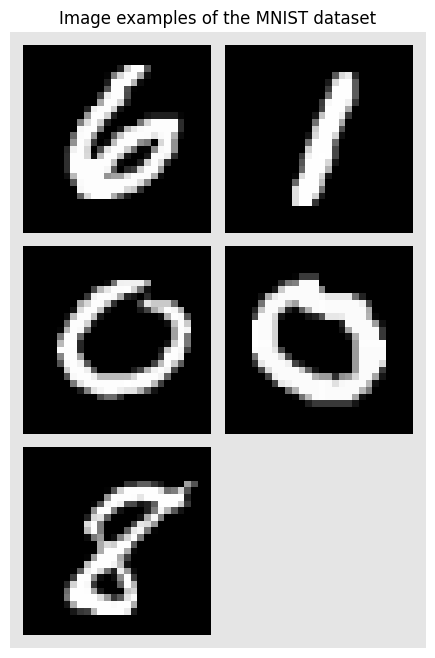

In [38]:
# Visualize some examples
NUM_IMAGES = 5
MNIST_examples = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_examples, nrow=2, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [39]:
image_size = 28
embed_dim=256
hidden_dim=embed_dim*3
num_heads=8
num_layers=6
patch_size=7
num_patches=16
num_channels=1
num_classes=10
dropout=0.2

In [40]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape # [B, C, H, W], MNIST [B, 1, 28, 28]
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size) # [B, C, H', p_H, W', p_W], MNIST [B, 1, 4, 7, 4, 7]
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W], MNIST [B, 4, 4, 1, 7, 7]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W], MNIST [B, 16, 1, 7, 7]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W], MNIST [B, 16, 49]
    return x

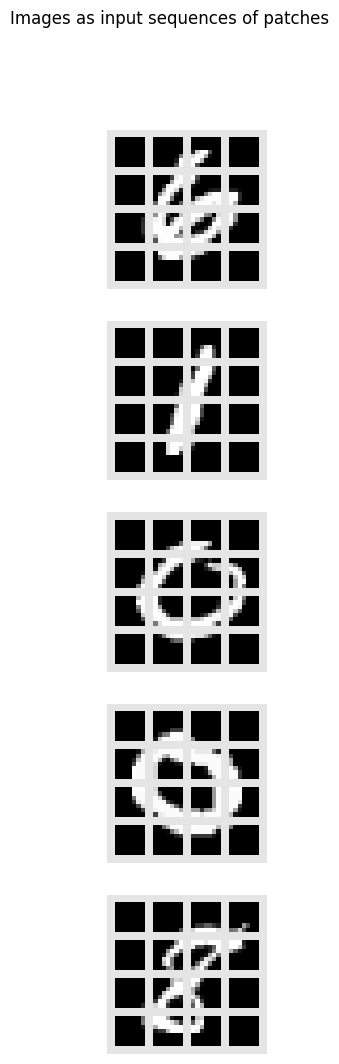

In [41]:

# Visualize the image patches
img_patches = img_to_patch(MNIST_examples, patch_size=patch_size, flatten_channels=False)

fig, ax = plt.subplots(MNIST_examples.shape[0], 1, figsize=(14, 12))
fig.suptitle("Images as input sequences of patches")
for i in range(MNIST_examples.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=int(image_size/patch_size), normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

In [42]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [43]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB or 1 for grayscale)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)        # x.shape ---> batch, num_patches, (patch_size**2)
        B, T, _ = x.shape
        x = self.input_layer(x)                     # x.shape ---> batch, num_patches, embed_dim

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)        # x.shape ---> batch, num_patches+1, embed_dim
        x = x + self.pos_embedding[:, : T + 1]      # x.shape ---> batch, num_patches+1, embed_dim

        # Apply Transformer
        x = self.dropout(x)
        x = x.transpose(0, 1)                       # x.shape ---> num_patches+1, batch, embed_dim
        x = self.transformer(x)                     # x.shape ---> num_patches+1, batch, embed_dim

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [44]:
model = VisionTransformer(embed_dim=embed_dim,
                          hidden_dim=hidden_dim,
                          num_heads=num_heads,
                          num_layers=num_layers,
                          patch_size=patch_size,
                          num_channels=num_channels,
                          num_patches=num_patches,
                          num_classes=num_classes,
                          dropout=dropout)

# Transfer to GPU
model.to(device)
model_restore = None #'/content/model_20230712_211204_0'
if model_restore is not None and os.path.exists(model_restore):
  model.load_state_dict(torch.load(model_restore))
  model.restored = True

In [45]:
model

VisionTransformer(
  (input_layer): Linear(in_features=49, out_features=256, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=768, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): Layer

In [46]:
# setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()
# setup the optimizer with the learning rate
model_optimizer = optim.Adam(model.parameters(), lr=3e-4)
# set a scheduler to decay the learning rate by 0.1 on the 100th 150th epochs
model_scheduler = optim.lr_scheduler.MultiStepLR(model_optimizer,
                                            milestones=[100, 150], gamma=0.1)

In [47]:
# Function to evaluate model performance on the test set
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [48]:
num_clients = 4

print("len of train_set::",len(train_set))

# Define the digit exclusions for each client
digit_exclusions = {
    0: [5],                   # Client 0 does not have digit 5
    1: [4],                # Client 1 does not have digits 3, 4
    2: [9],                   # Client 2 does not have digit 9
    3: [8]             # Client 3 does not have digits 8, 7, 6                  # Client 4 does not have digit 2
}
# Initialize lists to hold client indices
client_indices = {i: [] for i in range(len(digit_exclusions))}

# Initialize a global index pool and digit-specific pools
global_index_pool = list(range(len(train_set)))

client_datasets = {}
client_indices_mapping = {}  # To store the indices allocated to each client
for client_idx in range(len(digit_exclusions)):
    # Filter the global index pool for the current client
    available_indices = [idx for idx in global_index_pool if train_set[idx][1] not in digit_exclusions[client_idx]]
    
    # Sample 10,000 unique indices for the current client
    sampled_indices = random.sample(available_indices, 10000)
    
    # Assign to the client dataset and store the indices
    client_datasets[client_idx] = Subset(train_set, sampled_indices)
    client_indices_mapping[client_idx] = sampled_indices
    
    # Remove the sampled indices from the global pool
    global_index_pool = [idx for idx in global_index_pool if idx not in sampled_indices]

# Create DataLoaders for each client
client_loaders = {
    client_idx: DataLoader(dataset=dataset, batch_size=32, shuffle=True)
    for client_idx, dataset in client_datasets.items()
}

# Calculate and print the length of each client's dataset
client_data_sizes = [len(client_datasets[i]) for i in range(num_clients)]
print("Client data sizes:", client_data_sizes)

# Print the indices allocated to each client
for client_idx, indices in client_indices_mapping.items():
    print(f"Client {client_idx} has indices: {indices[:20]} ...")  # Printing first 20 indices for brevity
    print(f"Total indices for Client {client_idx}: {len(indices)}")

# Display unique labels for each client
for client_idx in range(len(client_datasets)):
    labels = [train_set[idx][1] for idx in client_datasets[client_idx].indices]
    unique_labels = set(labels)
    print(f"Client {client_idx} has the following labels: {sorted(unique_labels)}")

len of train_set:: 50000
Client data sizes: [10000, 10000, 10000, 10000]
Client 0 has indices: [46084, 7984, 1783, 19777, 17624, 16072, 10005, 7366, 48754, 39320, 6248, 42565, 30379, 2259, 2120, 6732, 15733, 16750, 36440, 43399] ...
Total indices for Client 0: 10000
Client 1 has indices: [17156, 35042, 38256, 28881, 32954, 11481, 47039, 20079, 9682, 35695, 838, 48742, 41648, 28538, 13147, 26797, 19771, 45171, 41202, 13386] ...
Total indices for Client 1: 10000
Client 2 has indices: [13421, 19696, 40421, 39943, 36294, 21839, 39147, 14831, 31258, 8314, 39602, 33776, 45772, 1066, 49480, 17264, 164, 20773, 24586, 40004] ...
Total indices for Client 2: 10000
Client 3 has indices: [2620, 21884, 2133, 44571, 18740, 42471, 11854, 33811, 5251, 42255, 14993, 373, 8589, 24503, 48041, 37906, 43179, 49552, 1727, 49745] ...
Total indices for Client 3: 10000
Client 0 has the following labels: [0, 1, 2, 3, 4, 6, 7, 8, 9]
Client 1 has the following labels: [0, 1, 2, 3, 5, 6, 7, 8, 9]
Client 2 has the f

In [49]:
# Create a function to train locally on a client
def train_local_model(model, train_loader, loss_fn, optimizer, device, epochs):
    model.train()
    for epoch in range(epochs):
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(imgs)
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()

In [50]:
# Function for FedAvg (Federated Averaging)
def federated_averaging(global_model, client_models, client_data_sizes):
    global_dict = global_model.state_dict()
    total_data_points = sum(client_data_sizes)  # Total number of data points across all clients
    
    # Initialize the global state with zeros
    for key in global_dict.keys():
        global_dict[key] = torch.zeros_like(global_dict[key])
    
    # Perform weighted averaging
    for i, client_model in enumerate(client_models):
        client_dict = client_model.state_dict()
        weight = client_data_sizes[i] / total_data_points  # Compute weight for this client
        for key in global_dict.keys():
            global_dict[key] += client_dict[key] * weight
    
    # Load the weighted average back into the global model
    global_model.load_state_dict(global_dict)


In [55]:
# To check each client model performance in centralized setting
centralized_client_models = [copy.deepcopy(model) for _ in range(num_clients)]
epochs_per_client = 50  # Number of local epochs per client

In [56]:
# Performing centralized training of each client model
print("Performing centralized training of each client")
for client_idx in range(num_clients):
    print(f'Client {client_idx+1} training...')
    train_local_model(centralized_client_models[client_idx], client_loaders[client_idx], loss_fn, 
                          optim.Adam(centralized_client_models[client_idx].parameters(), lr=3e-4), device, epochs=epochs_per_client)

    accuracy=evaluate_model(centralized_client_models[client_idx], test_loader, device)
    print("accuracy:",accuracy)

Performing centralized training of each client
Client 1 training...
accuracy: 0.8853
Client 2 training...
accuracy: 0.8738
Client 3 training...
accuracy: 0.8728
Client 4 training...
accuracy: 0.8762


In [58]:
def generate_attention_heatmap(model, img_tensor, patch_size, image_size):
    # Convert the test sample into patches
    patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
    # Run the patches through the input layer to get a tensor of size embed_dim
    patches = model.input_layer(patches.float())
    # Attach the class token and add the position embedding
    transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding
    
    # Run the embedded test image through the first attention block and squeeze the batch dimension
    transformer_input_expanded = model.transformer[0].linear[0](transformer_input).squeeze(0)
    
    # Reshape the output of the first attention block
    qkv = transformer_input_expanded.reshape(num_patches+1, 3, num_heads, -1)
    
    # Extract query and key matrices
    q = qkv[:, 0].permute(1, 0, 2)
    k = qkv[:, 1].permute(1, 0, 2)
    kT = k.permute(0, 2, 1)
    
    # Compute attention matrix
    attention_matrix = q @ kT
    
    # Average the attention weights across all heads
    attention_matrix_mean = torch.mean(attention_matrix, dim=0)
    
    # Add residual connection
    residual_att = torch.eye(attention_matrix_mean.size(1)).to(device)
    aug_att_mat = attention_matrix_mean + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    
    # Reshape attention map to match image size
    attn_heatmap = aug_att_mat[0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
    attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), 
                                         [image_size, image_size], mode='bilinear').view(28, 28, 1)
    return attn_heatmap_resized

In [66]:
# Pull out one test sample present in client 2 already (you can also verify those samples which are excluded in client dataset)
test_sample_index = (test_set.targets==5).nonzero(as_tuple=True)[0][2].item()
img_tensor = test_set.data[test_sample_index].to(device)

# Federated Clients' Model Attention Map
attn_heatmap_client1_centralized = generate_attention_heatmap(centralized_client_models[2], img_tensor, patch_size, image_size)

****** Client 2******


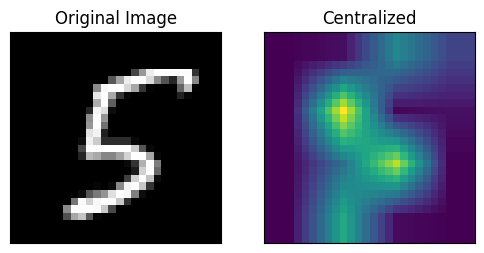

In [67]:
# Plot comparison of attention maps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
print("****** Client 2******")
# Original MNIST test image
img = np.asarray(img_tensor.cpu())
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image')
ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)

# Centralized Model Attention Map
ax2.imshow(attn_heatmap_client1_centralized.detach().cpu().numpy())
ax2.set_title('Centralized')
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)

In [73]:
# Federated Learning Setup
global_model = copy.deepcopy(model)  # Global model
client_models = [copy.deepcopy(model) for _ in range(num_clients)]  # Local models for each client

# Training loop for Federated Learning
num_rounds = 10  # Number of communication rounds
epochs_per_client = 50  # Number of local epochs per client

In [74]:
for round_num in range(num_rounds):
    print(f'\nCommunication Round {round_num+1}/{num_rounds}')

    # Synchronize client models with the updated global model
    for client_idx in range(num_clients):
        client_models[client_idx].load_state_dict(global_model.state_dict())
    
    # Train each client's model locally
    for client_idx in range(num_clients):
        print(f'Client {client_idx+1} training...')
        train_local_model(client_models[client_idx], client_loaders[client_idx], loss_fn, 
                          optim.Adam(client_models[client_idx].parameters(), lr=3e-4), device, epochs=epochs_per_client)
        accuracy=evaluate_model(client_models[client_idx], test_loader, device)
        print("accuracy:",accuracy)
    
    # Aggregate client models to update global model
    federated_averaging(global_model, client_models,client_data_sizes)


Communication Round 1/10
Client 1 training...
accuracy: 0.8838
Client 2 training...
accuracy: 0.8763
Client 3 training...
accuracy: 0.8743
Client 4 training...
accuracy: 0.8739

Communication Round 2/10
Client 1 training...
accuracy: 0.8855
Client 2 training...
accuracy: 0.8679
Client 3 training...
accuracy: 0.8737
Client 4 training...
accuracy: 0.8788

Communication Round 3/10
Client 1 training...
accuracy: 0.89
Client 2 training...
accuracy: 0.8812
Client 3 training...
accuracy: 0.8791
Client 4 training...
accuracy: 0.8817

Communication Round 4/10
Client 1 training...
accuracy: 0.8871
Client 2 training...
accuracy: 0.8835
Client 3 training...
accuracy: 0.8794
Client 4 training...
accuracy: 0.8861

Communication Round 5/10
Client 1 training...
accuracy: 0.8911
Client 2 training...
accuracy: 0.8846
Client 3 training...
accuracy: 0.8818
Client 4 training...
accuracy: 0.8805

Communication Round 6/10
Client 1 training...
accuracy: 0.8947
Client 2 training...
accuracy: 0.8826
Client 3 t

In [79]:
# Pull out one test sample present in client 2 already (you can also verify those samples which are excluded in client dataset)
test_sample_index = (test_set.targets==5).nonzero(as_tuple=True)[0][2].item()
img_tensor = test_set.data[test_sample_index].to(device)

# Federated Clients' Model Attention Map
attn_heatmap_client1_federated = generate_attention_heatmap(client_models[2], img_tensor, patch_size, image_size)

****** Client 2******


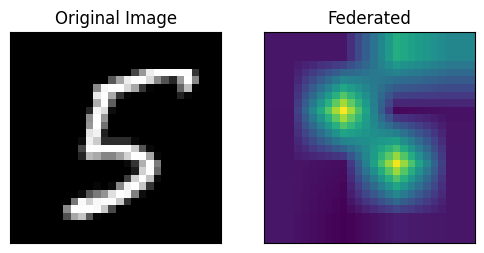

In [80]:
# Plot comparison of attention maps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
print("****** Client 2******")
# Original MNIST test image
img = np.asarray(img_tensor.cpu())
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image')
ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
# Federated Learning Client Model Attention Map
ax2.imshow(attn_heatmap_client1_federated.detach().cpu().numpy(),)
ax2.set_title('Federated')
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
plt.show()

In [81]:
test_sample_index = (test_set.targets==9).nonzero(as_tuple=True)[0][2].item()
img_tensor = test_set.data[test_sample_index].to(device)

# Federated Clients' Model Attention Map
attn_heatmap_client1_federated = generate_attention_heatmap(client_models[2], img_tensor, patch_size, image_size)
attn_heatmap_client1_centralized= generate_attention_heatmap(centralized_client_models[2], img_tensor, patch_size, image_size)

****** Client 2******


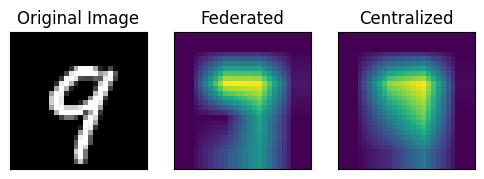

In [82]:
# Plot comparison of attention maps
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 6))
print("****** Client 2******")
# Original MNIST test image
img = np.asarray(img_tensor.cpu())
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image')
ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
# Federated Learning Client Model Attention Map
ax2.imshow(attn_heatmap_client1_federated.detach().cpu().numpy(),)
ax2.set_title('Federated')
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)

ax3.imshow(attn_heatmap_client1_centralized.detach().cpu().numpy(),)
ax3.set_title('Centralized')
ax3.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)

plt.show()

In [ ]:
# In a similar way, heatmaps can be visualized for all clients!